# Example of the import of custom fuzzy values
- This notebook reads in raw values and defines own fuzzy concepts, the same could be done when reading files already containing fuzzy values
  
- It also shows the application of different types of fuzzy values
- A pattern is defined, for which the input is visualized

---
Author: Felix Offensperger

/tmp/ipykernel_28622/1716559514.py:73: RuntimeWarning: divide by zero encountered in log10
  neglog10padj = -np.log10(deseq_results["padj"].to_numpy())


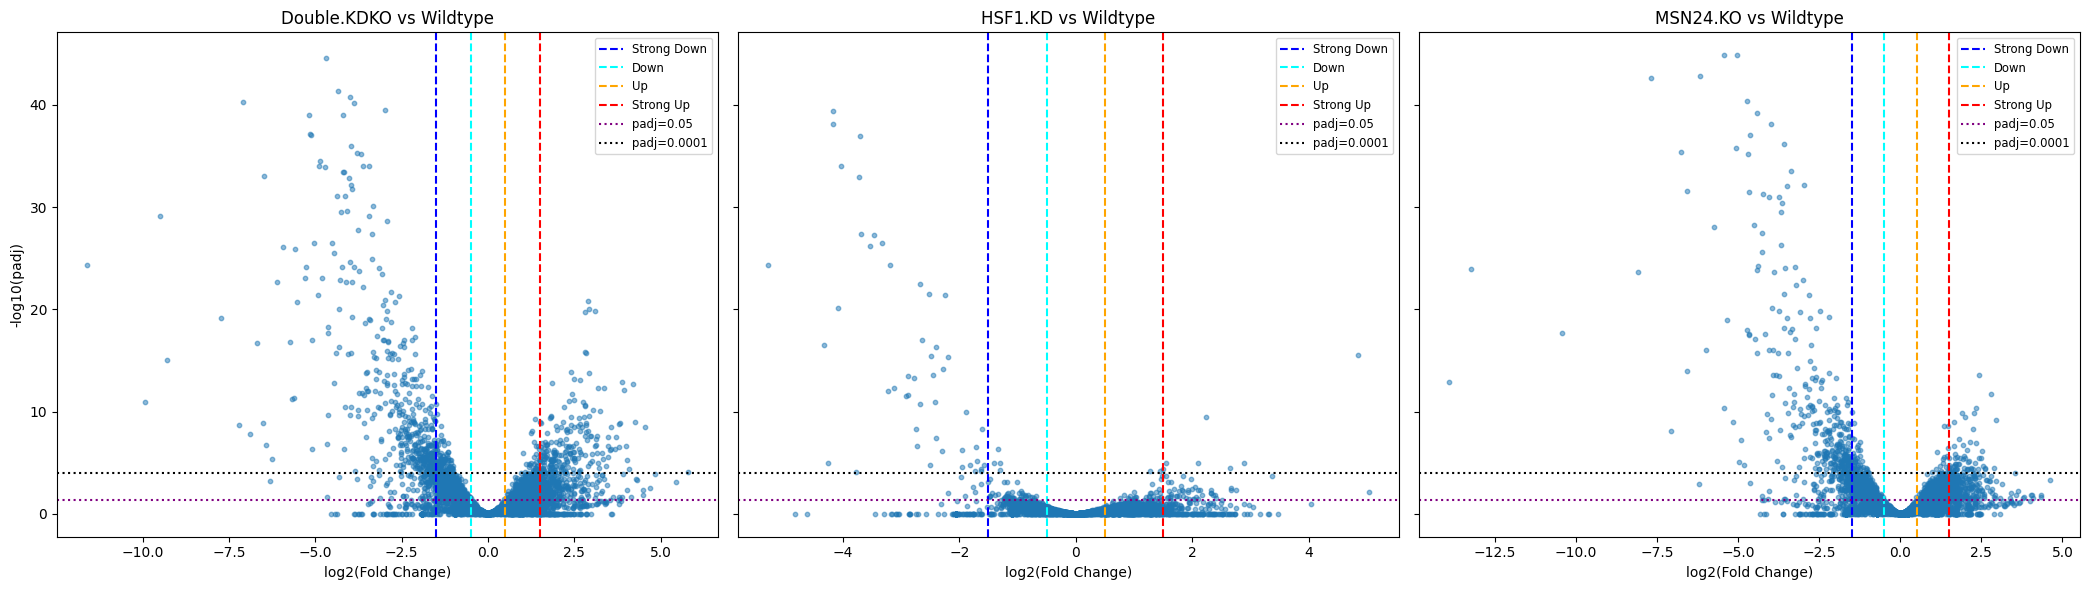

In [1]:
import sys,numpy as np,polars as pl

# Enable autoreload for development (reloads modules before executing code)
%load_ext autoreload

# Set up Python path to include parent directory for local imports
import matplotlib.pyplot as plt


# Automatically reload modules before executing code
%autoreload 2
schema = {
    "baseMean": pl.Float32,
    "log2FoldChange": pl.Float32,
    "lfcSE": pl.Float32,
    "stat": pl.Float32,
    "pvalue": pl.Float32,
    "padj": pl.Float32,
    "comparison": pl.Utf8,
    "gene_id": pl.Utf8
}

# Read the cleaned results
deseq_results = pl.read_csv(
    './data/deseq2_results_37deg_10min_all_comparisons.csv',
    null_values=['NA'],
    schema=schema
)

deseq_results = deseq_results.with_columns(
    pl.col("log2FoldChange").fill_null(0),
    pl.col("padj").fill_null(1),
)

def piecewise_fuzzify(values, boundaries, classes):
    memberships = np.zeros((len(values), len(classes)))
    for idx, v in enumerate(values):
        assigned = False
        # Check boundaries for mixed regions
        for b in range(len(boundaries)):
            if np.isclose(v, boundaries[b], rtol=0.1):
                memberships[idx, b] = 0.5
                memberships[idx, b+1] = 0.5
                assigned = True
                break
        if assigned:
            continue
        # Assign hard regions
        if v < boundaries[0]:
            memberships[idx, 0] = 1
        elif v > boundaries[-1]:
            memberships[idx, -1] = 1
        else:
            for b in range(len(boundaries)-1):
                if boundaries[b] < v < boundaries[b+1]:
                    memberships[idx, b+1] = 1
                    break
    return memberships, classes



# Define boundaries for fold change and padj
fc_boundaries = np.array([-1.5, -.5, .5, 1.5])
fc_classes = ["strong_down", "down", "neutral", "up", "strong_up"]

padj_boundaries = np.array([0.0001, 0.05])
padj_classes = ["very_significant", "significant", "non_significant"]

fc_membership, fc_classes = piecewise_fuzzify(deseq_results["log2FoldChange"].to_numpy(), fc_boundaries, fc_classes)
padj_membership, padj_classes = piecewise_fuzzify(deseq_results["padj"].to_numpy(), padj_boundaries, padj_classes)

log2fc= deseq_results["log2FoldChange"].to_numpy()
neglog10padj = -np.log10(deseq_results["padj"].to_numpy())
unique_comparisons= deseq_results["comparison"].unique().to_list()
# Volcano plot
# Facet volcano plot by comparison
fig, axes = plt.subplots(1, len(unique_comparisons), figsize=(7 * len(unique_comparisons), 6), sharey=True)

if len(unique_comparisons) == 1:
    axes = [axes]

for i, comp in enumerate(unique_comparisons):
    ax = axes[i]
    mask = deseq_results["comparison"] == comp
    ax.scatter(
        log2fc[mask],
        neglog10padj[mask],
        s=10,
        alpha=0.5
    )
    ax.axvline(x=-1.5, color='blue', linestyle='--', label='Strong Down')
    ax.axvline(x=-.5, color='cyan', linestyle='--', label='Down')
    ax.axvline(x=.5, color='orange', linestyle='--', label='Up')
    ax.axvline(x=1.5, color='red', linestyle='--', label='Strong Up')
    ax.axhline(y=-np.log10(0.05), color='purple', linestyle=':', label='padj=0.05')
    ax.axhline(y=-np.log10(0.0001), color='black', linestyle=':', label='padj=0.0001')
    ax.set_xlabel('log2(Fold Change)')
    ax.set_title(comp)
    if i == 0:
        ax.set_ylabel('-log10(padj)')
    ax.legend(loc='upper right', fontsize='small')

plt.tight_layout()
plt.show()


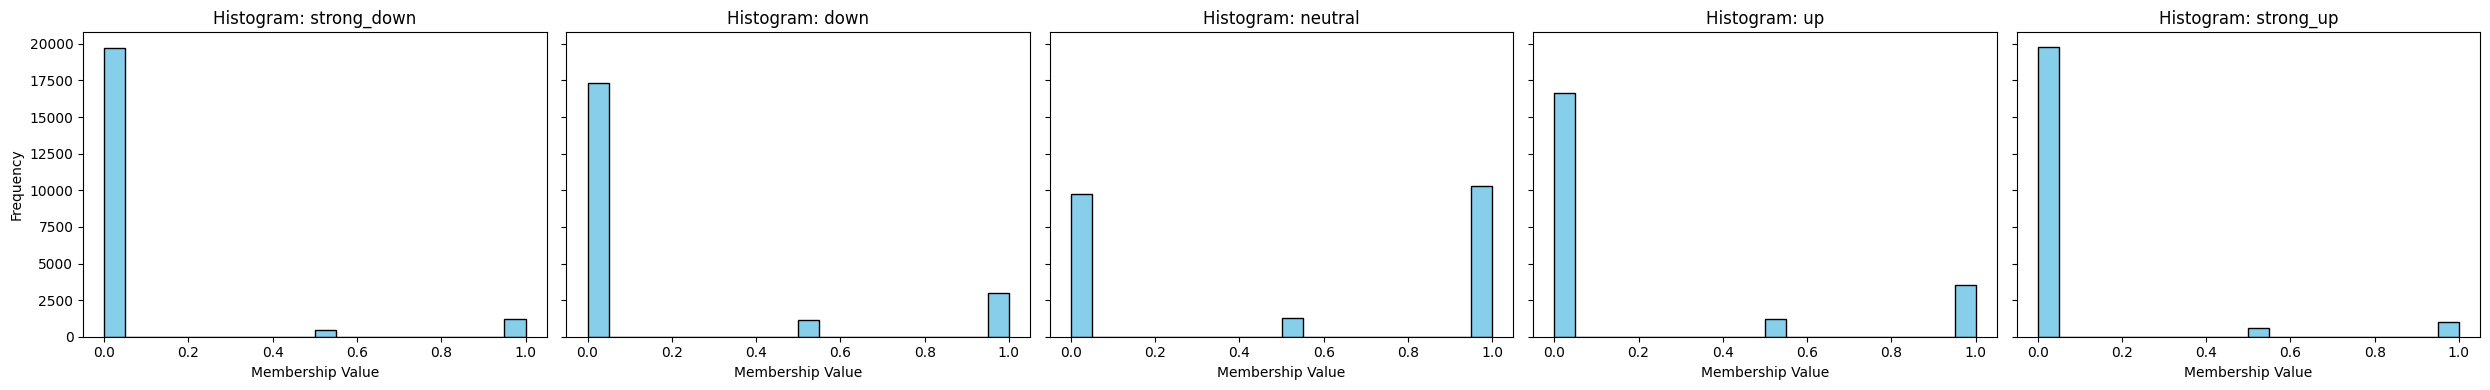

In [2]:
# Plot histogram of all_fc_memberships faceted by membership column (class)
n_classes = fc_membership.shape[1]
fig, axes = plt.subplots(1, n_classes, figsize=(5 * n_classes, 4), sharey=True)

for i in range(n_classes):
    axes[i].hist(fc_membership[:, i], bins=20, color='skyblue', edgecolor='black')
    axes[i].set_title(f'Histogram: {fc_classes[i]}')
    axes[i].set_xlabel('Membership Value')
    if i == 0:
        axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [3]:
gene_ids = deseq_results["gene_id"].to_numpy()

class fuzzy:
    def __init__ (self, fuzzy_variables):
        self.terms = {fuzzy_var:[] for fuzzy_var in fuzzy_variables}

# Helper function to build wide DataFrame and fuzzy dict for all comparisons
def build_fuzzy_wide_all(membership, classes, col_suffix):
    dfs = []
    fuzzy_dict = {}
    start = 0
    n_genes = len(gene_ids)
    n_classes = len(classes)
    for comp in unique_comparisons:
        # For each comparison, extract the relevant rows from deseq_results
        mask = (deseq_results["comparison"] == comp).to_numpy()
        comp_gene_ids = gene_ids[mask]
        comp_membership = membership[mask]
        colnames = [f"{cls}*{comp}_{col_suffix}" for cls in classes]
        df = pl.DataFrame(
            dict(
                gene_id=comp_gene_ids,
                **{col: comp_membership[:, i] for i, col in enumerate(colnames)}
            )
        )
        dfs.append(df)
        fuzzy_dict[f"{comp}_{col_suffix}"] = fuzzy(classes)
    # Merge all comparison DataFrames on gene_id (outer join to keep all genes)
    from functools import reduce
    df_wide = reduce(lambda left, right: left.join(right, on="gene_id", how="outer"), dfs)
    return df_wide, fuzzy_dict

# Build explDFWide and mfFuzzy for fold change
explDFWide, mfFuzzy = build_fuzzy_wide_all(fc_membership, fc_classes, "fc")

# Build explDFWide_sig and mfFuzzy_sig for significance
explDFWide_sig, mfFuzzy_sig = build_fuzzy_wide_all(padj_membership, padj_classes, "sig")

# Concatenate mfFuzzy and mfFuzzy_sig dictionaries
mfFuzzy_all = {**mfFuzzy, **mfFuzzy_sig}

# Merge explDFWide and explDFWide_sig on 'gene_id'
explDFWide_merged = explDFWide.join(explDFWide_sig, on="gene_id", how="inner")


/tmp/ipykernel_28622/3339302988.py:30: DeprecationWarning: Use of `how='outer'` should be replaced with `how='full'`.
  df_wide = reduce(lambda left, right: left.join(right, on="gene_id", how="outer"), dfs)


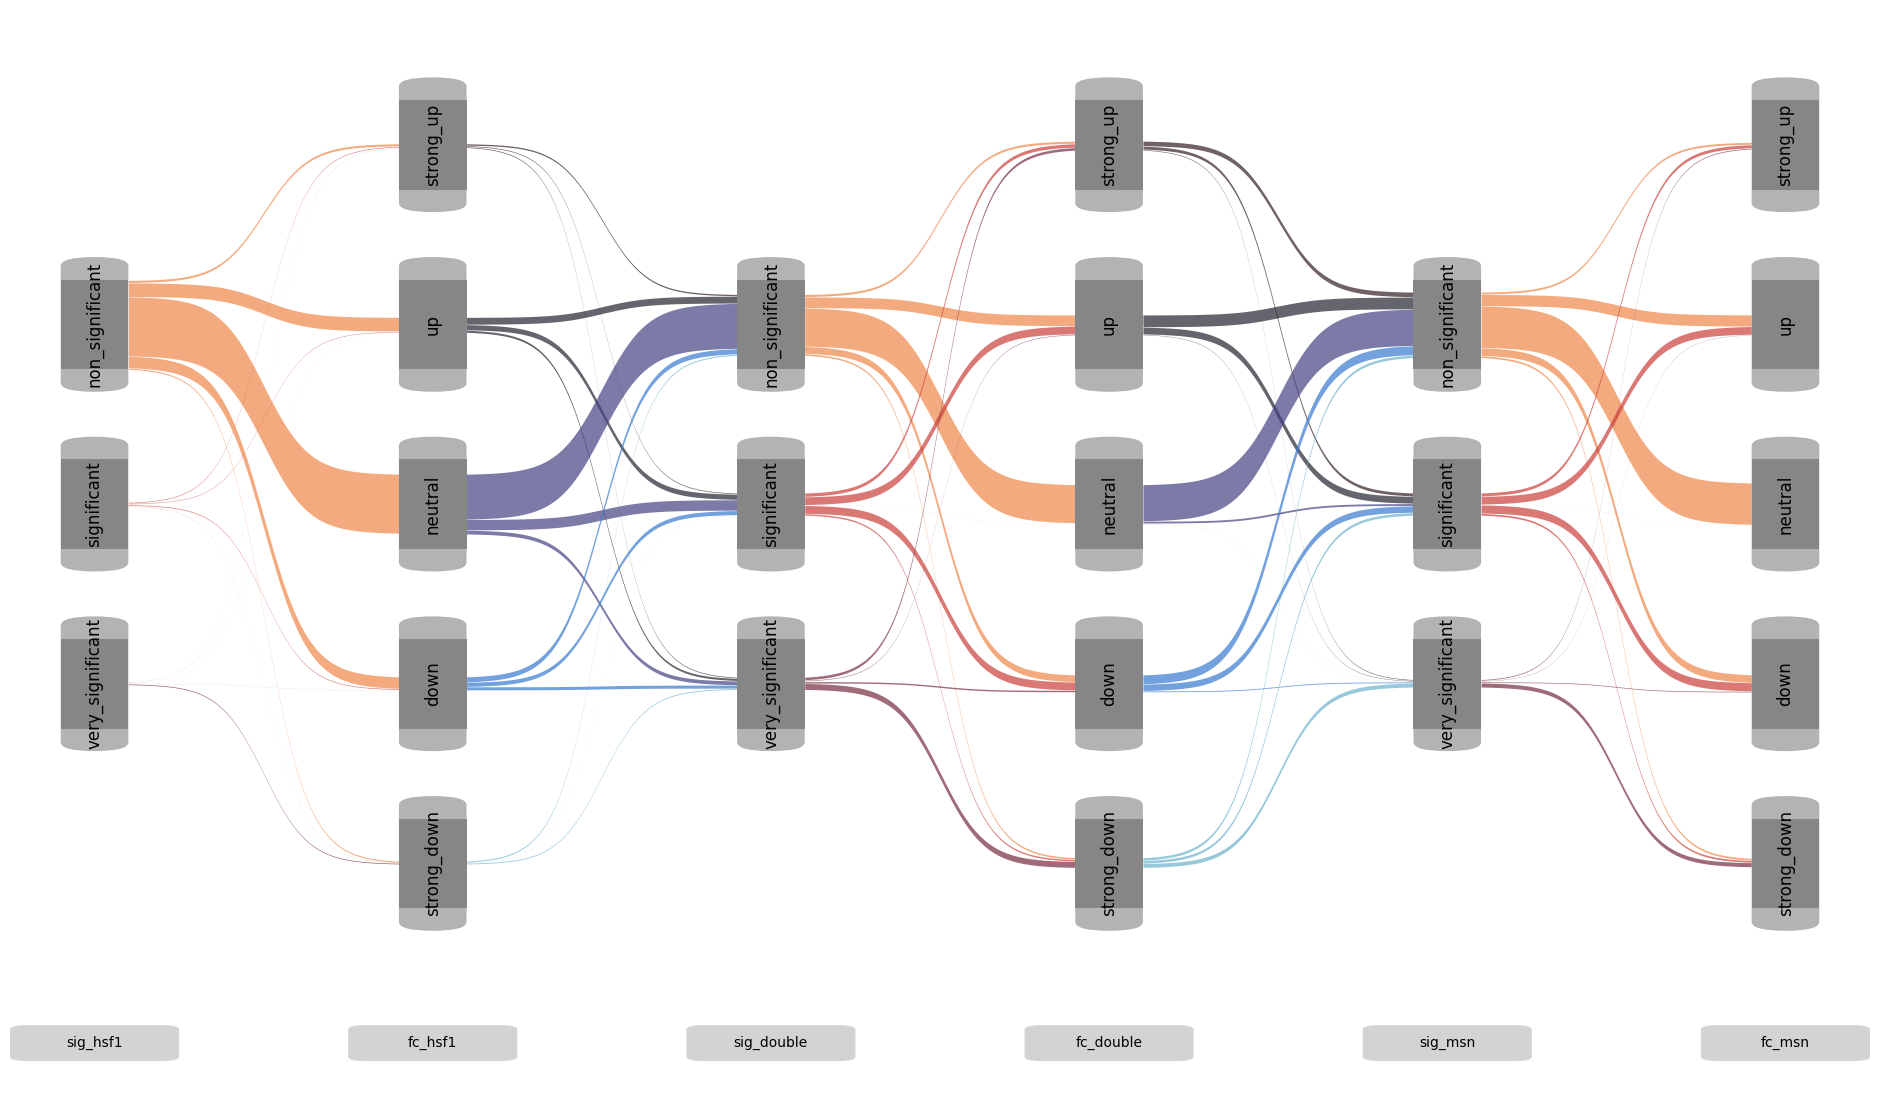

In [4]:
# Now we can import the custom fuzzy values into FlowSets
# series2name has to match explDFWide_merged


from flowsets import *

series2name=(
        ("HSF1.KD vs Wildtype_sig",'sig_hsf1'),
        ("HSF1.KD vs Wildtype_fc",'fc_hsf1'),
        ("Double.KDKO vs Wildtype_sig",'sig_double'),
        ("Double.KDKO vs Wildtype_fc",'fc_double'),
        ("MSN24.KO vs Wildtype_sig",'sig_msn'),
        ("MSN24.KO vs Wildtype_fc",'fc_msn')
    )

fa= FlowAnalysis(explDFWide_merged,"gene_id", series2name, mfFuzzy_all,sep="*") 
fa.plot_flows()

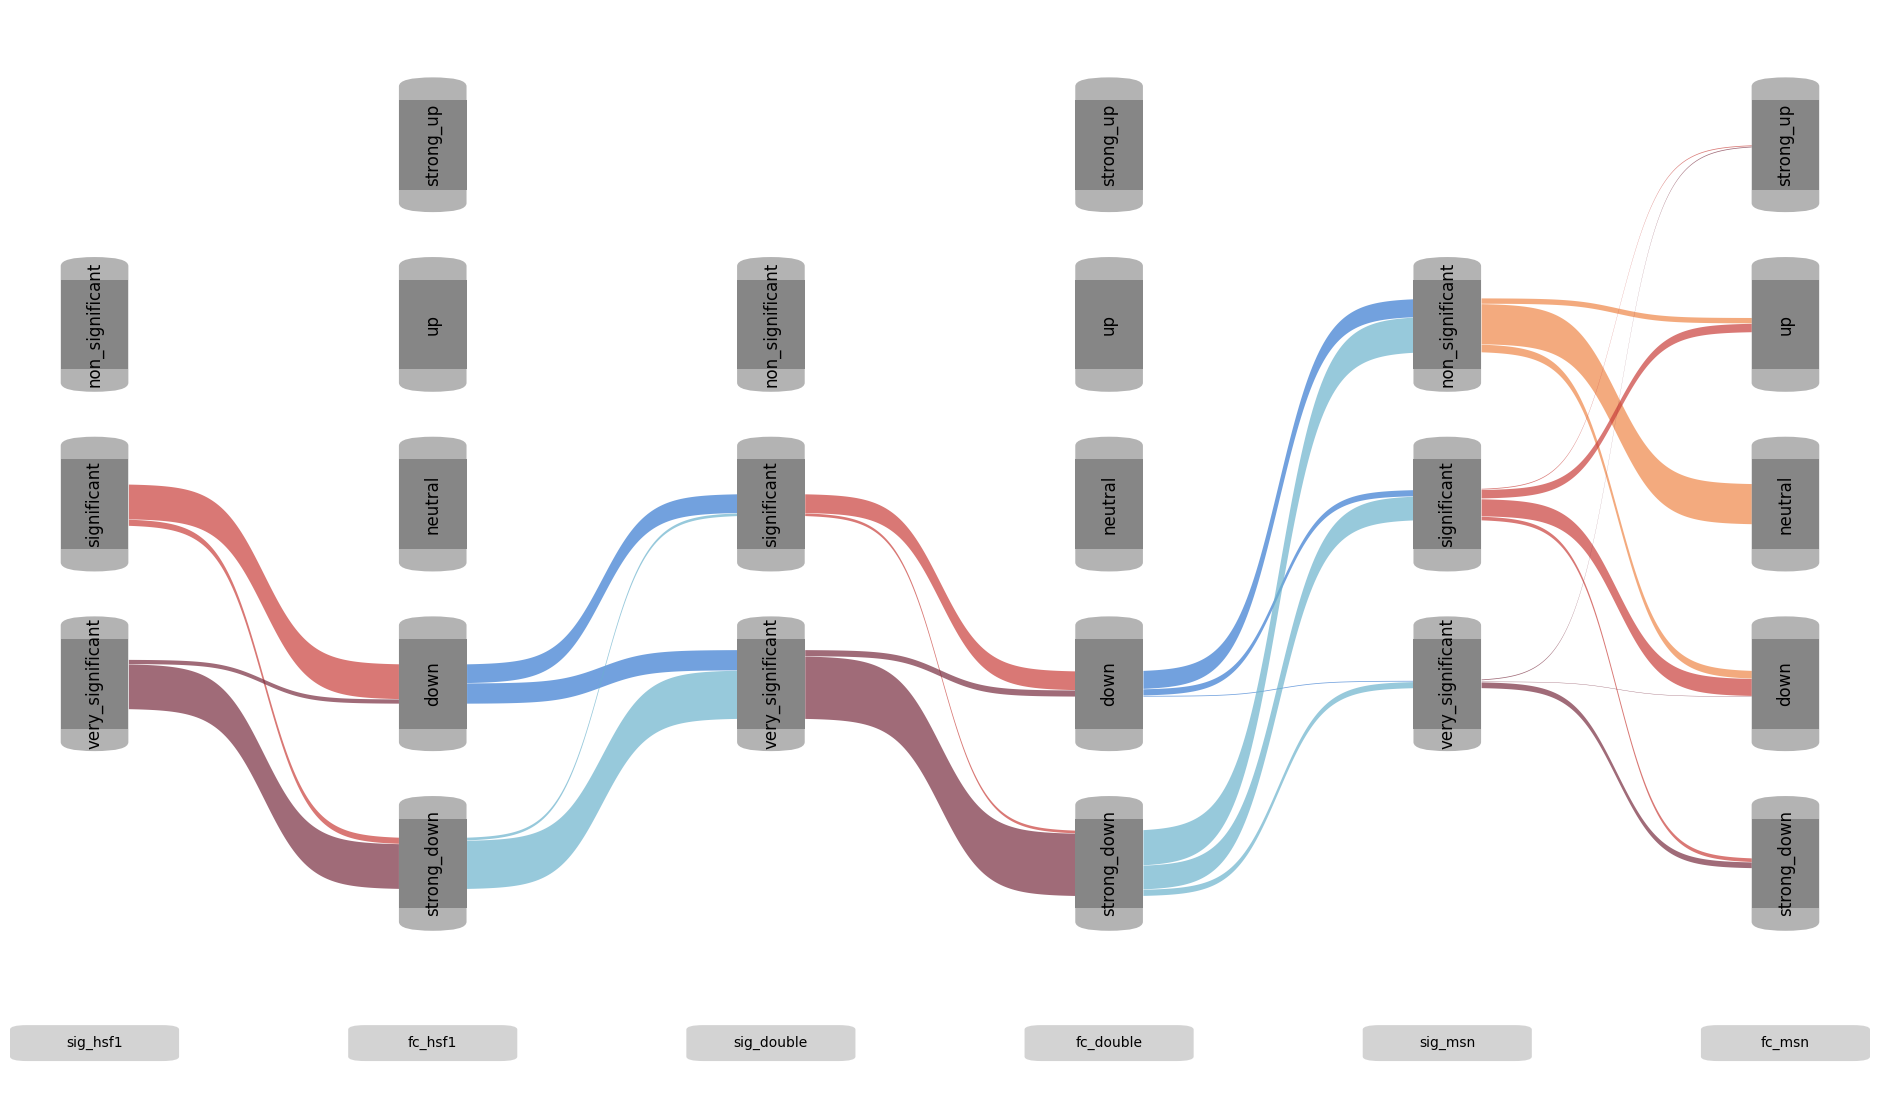

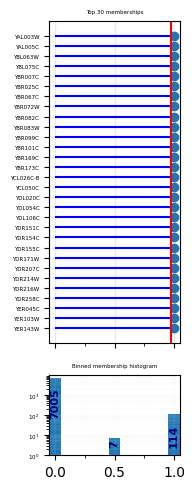

(shape: (30, 2)
 ┌─────────┬────────────┐
 │ gene_id ┆ membership │
 │ ---     ┆ ---        │
 │ str     ┆ f64        │
 ╞═════════╪════════════╡
 │ YAL003W ┆ 1.0        │
 │ YAL005C ┆ 1.0        │
 │ YBL063W ┆ 1.0        │
 │ YBL075C ┆ 1.0        │
 │ YBR007C ┆ 1.0        │
 │ …       ┆ …          │
 │ YDR216W ┆ 1.0        │
 │ YDR258C ┆ 1.0        │
 │ YER045C ┆ 1.0        │
 │ YER103W ┆ 1.0        │
 │ YER143W ┆ 1.0        │
 └─────────┴────────────┘,
 <Axes: title={'center': 'Top 30 memberships'}>,
 <Axes: title={'center': 'Binned membership histogram'}>)

In [5]:
# A pattern can be defined
relFlow=fa.flow_finder(["?","?","?","?","?"],minLevels=[None,None,None,None,None,None],maxLevels=["significant","down","significant","down",None,None],verbose=False)
fa.plot_flows(use_edges=relFlow)
fa.plot_flow_memberships(use_edges=relFlow)


/tmp/ipykernel_28622/3130480752.py:16: RuntimeWarning: divide by zero encountered in log10
  (-np.log10(comp_df["padj"].to_numpy())),


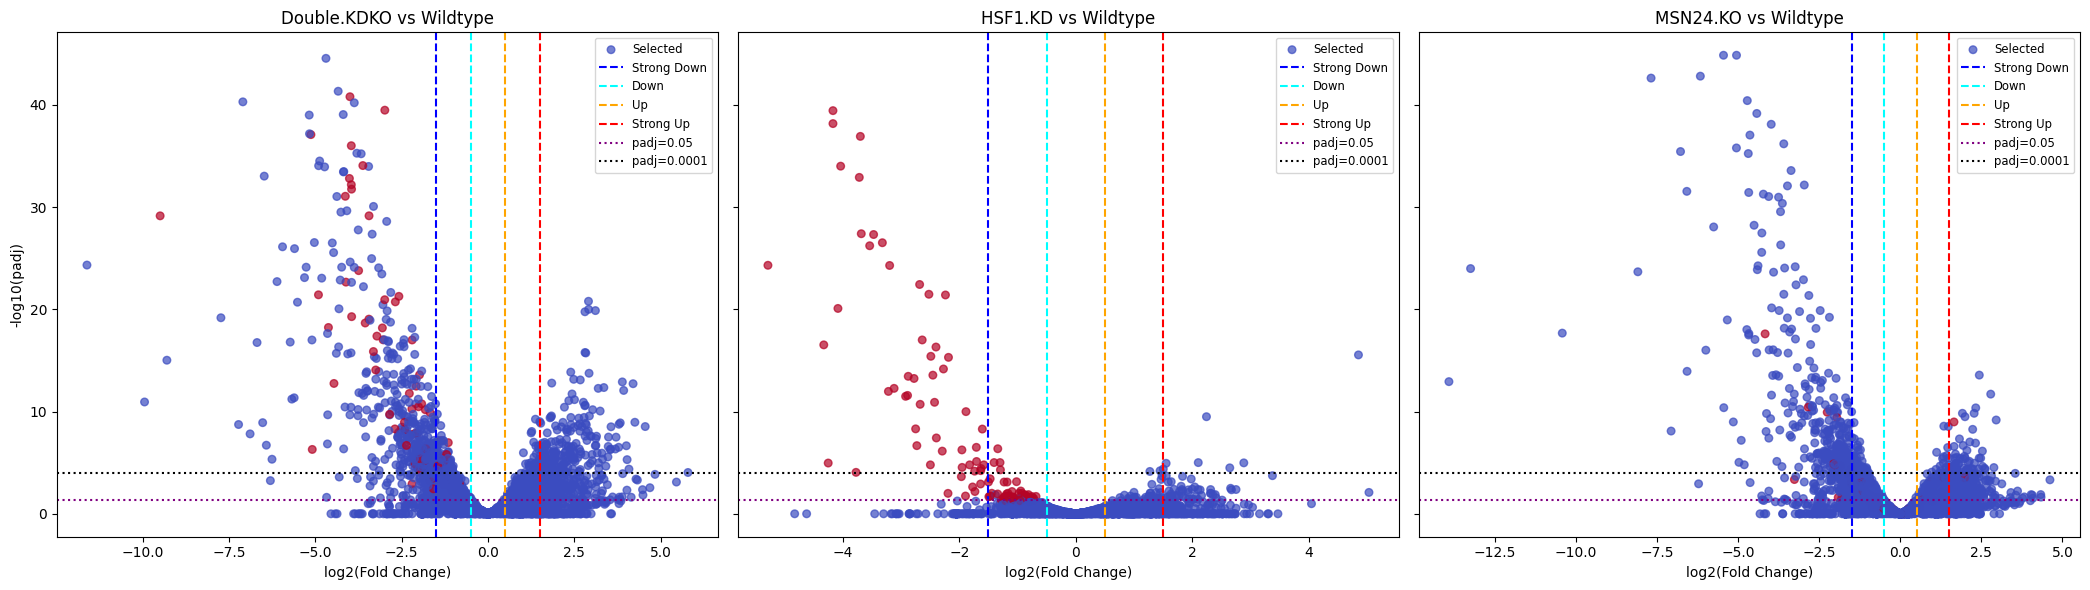

In [6]:
# And the selected genes can be visualized in the input data
# The selected genes are those with a membership > 0.20 in the pattern

selected_genes = fa.calc_coarse_flow_memberships(use_edges=relFlow).to_pandas()
high_membership = selected_genes[selected_genes['membership'] > 0.20]
fig, axes = plt.subplots(1, len(unique_comparisons), figsize=(7 * len(unique_comparisons), 6), sharey=True)
selected_mask = deseq_results["gene_id"].is_in(high_membership["gene_id"])
for i, comp in enumerate(unique_comparisons):
    ax = axes[i]
    mask = (deseq_results["comparison"] == comp)
    # Use filter instead of boolean indexing
    comp_df = deseq_results.filter(mask)
    comp_selected_mask = selected_mask.filter(mask)
    ax.scatter(
        comp_df["log2FoldChange"].to_numpy(),
        (-np.log10(comp_df["padj"].to_numpy())),
        s=30,
        c=comp_selected_mask.to_numpy(),  # Use 'c' for color mapping
        cmap='coolwarm',   # Optional: choose a colormap
        alpha=0.7,
        label='Selected'
    )
    ax.axvline(x=-1.5, color='blue', linestyle='--', label='Strong Down')
    ax.axvline(x=-.5, color='cyan', linestyle='--', label='Down')
    ax.axvline(x=.5, color='orange', linestyle='--', label='Up')
    ax.axvline(x=1.5, color='red', linestyle='--', label='Strong Up')
    ax.axhline(y=-np.log10(0.05), color='purple', linestyle=':', label='padj=0.05')
    ax.axhline(y=-np.log10(0.0001), color='black', linestyle=':', label='padj=0.0001')
    ax.set_xlabel('log2(Fold Change)')
    ax.set_title(comp)
    if i == 0:
        ax.set_ylabel('-log10(padj)')
    ax.legend(loc='upper right', fontsize='small')

plt.tight_layout()
plt.show()